In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import torch.nn as nn

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.



In [0]:
import torchvision
import torchvision.transforms as transforms


<h3> Loading Data </h3>

<p><b>Note:</b> The CIFAR 10 dataset has been used. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.
</p>

https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
trainset = torchvision.datasets.CIFAR10('./data', train=True, download = True, transform = transforms.ToTensor())

0it [00:00, ?it/s]

170500096it [00:06, 27487698.77it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


More of torch.utils.data.DataLoader at https://pytorch.org/docs/stable/data.html

In [0]:
#shuffle ensures randomness when loading the data
#batch size = number of samples used before updating internal model parameters
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [6]:
len(trainloader)

12500

In [7]:
len(trainset)

50000

len(trainloader) x batch_size = len(trainset)

So length of train loader varies according to batch size

https://discuss.pytorch.org/t/about-the-relation-between-batch-size-and-length-of-data-loader/10510/3

NOTE : iter() method is used to convert to convert an iterable to iterator. This presents another way to iterate the container i.e access its elements. iter() uses next() for accessing values.

In [8]:
dataiter = iter(trainloader) # dataiter contains set of 4 images
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
3


Each images is of size 32 x 32, with 3 channels. Its batch has 4 such images

<h3> Visualising Data </h3>

In [0]:
# 10 classes in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
img = images[1]
print(type(img))
npimg = img.numpy()
print(npimg.shape)


<class 'torch.Tensor'>
(3, 32, 32)


In [11]:
# Since we want size of image to be (32,32,3) from (3,32,32) we use np.transpose
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

(32, 32, 3)


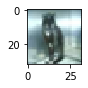

In [12]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [0]:
# Putting the above code into a function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

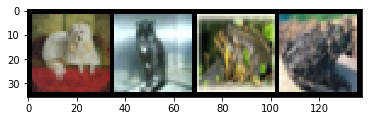

dog cat frog frog


In [14]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[label] for label in labels ))


<h3> Deep CNN </h3>

In [0]:
class CNN_v1(nn.Module):
  def __init__(self):
    #super().__init__() This was giving not implemented error
    super(CNN_v1, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,8,3), # depth of kernel = 3 , number of kernels = 8 , filter size = 3 x 3
        nn.Conv2d(8,16,3) # depth of kernel = 8 = number of kernels in previous layer
    )

#https://stackoverflow.com/questions/55932767/pytorchs-model-cant-feed-forward-a-dataloader-dataset-notimplementederror
#This function has to be named as forward, else it will give 'NotImplementedError'
  def forward(self, x):
    x = self.model(x)
    return x



In [16]:
net = CNN_v1()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded. This can be easily visualised using the torchviz package

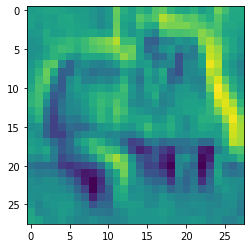

In [17]:
plt.imshow(out[0, 0, :, :].detach().numpy())

In [0]:
class CNN_v2(nn.Module):
    def __init__(self): 
        super(CNN_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
net = CNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

<h3> LeNet </h3>


In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    torch.manual_seed(0)
    self.cnn_model = nn.Sequential(
        # in channels is depth of the filter
        # out channels is number of filters used
        nn.Conv2d(in_channels = 3 , out_channels = 6, kernel_size = 5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride = 2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5 ),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride = 2)
    )

    self.fc_model = nn.Sequential(
            nn.Linear(in_features = 400,out_features = 120),         
            nn.Tanh(),
            nn.Linear(120,84),         
            nn.Tanh(),
            nn.Linear(84,10)           
             )
    
  def forward(self, x):
      print("Initial shape is",x.shape)
      x = self.cnn_model(x)
      print("Shape after passing through all CNN layes is",x.shape)
      x = x.view(x.size(0),-1) # Flattening 
      print("Shape after flattening and before passing to FC layer is ",x.shape)
      x = self.fc_model(x)  
      return x


<h3> Understanding LeNet Input and Output </h3>

In [21]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
inputs , labels= iter(trainloader).next()

In [0]:
net = LeNet()

In [25]:
#Pass input and see sizes after different stages
outputs = net(inputs)

Initial shape is torch.Size([128, 3, 32, 32])
Shape after passing through all CNN layes is torch.Size([128, 16, 5, 5])
Shape after flattening and before passing to FC layer is  torch.Size([128, 400])


In [0]:
#outputs[0].data

In [0]:
 _,pred = torch.max(outputs.data,1)

In [28]:
print(pred.shape)
print(labels.shape)

torch.Size([128])
torch.Size([128])


<h3> Training LeNet </h3>

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    torch.manual_seed(0)
    self.cnn_model = nn.Sequential(
        # in channels is depth of the filter
        # out channels is number of filters used
        nn.Conv2d(in_channels = 3 , out_channels = 6, kernel_size = 5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride = 2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5 ),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride = 2)
    )

    self.fc_model = nn.Sequential(
            nn.Linear(in_features = 400,out_features = 120),         
            nn.Tanh(),
            nn.Linear(120,84),         
            nn.Tanh(),
            nn.Linear(84,10)           
             )
    
  def forward(self, x):
      #print(x.shape)
      x = self.cnn_model(x)
      #print(x.shape)
      x = x.view(x.size(0),-1) # Flattening 
      #print(x.shape)
      x = self.fc_model(x)  
      return x


In [0]:

net = LeNet()

In [0]:
import torch.optim as optim

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/1, Test acc: 37.25, Train acc: 37.18


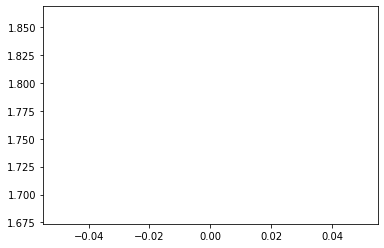

In [33]:
loss_arr = []
loss_epoch_arr = []
max_epochs = 1

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        opt.zero_grad() #Make all gradients zero

        outputs = net(inputs)
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Even for running 2 epochs we take a very long time so we go for GPU

<h3> Running LeNet on GPU </h3>

In [34]:
print(torch.cuda.device_count())

1


In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
def evaluation(dataloader):
  total, correct = 0,0
  for inputs, label in dataloader:
    inputs, label = inputs.to(device), label.to(device)
    outputs = net(inputs)
    #print(output.shape)
    _,pred = torch.max(outputs.data , -1) # See in more detail
    total += labels.size(0)
    correct += (pred == label).sum().item()
  return 100 * correct / total

In [0]:
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
# Weight decay helps in L2 Regularization
opt = optim.Adam(net.parameters(), weight_decay = 1e-5)

In [38]:
%%time
max_epochs = 4

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader,0):
    inputs , labels = data # you cannot do this in for loop itself because of the format in which enumerate returns data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    outputs = net(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

  
  print('Epoch: %d/%d' % (epoch, max_epochs))

  

Epoch: 0/4
Epoch: 1/4
Epoch: 2/4
Epoch: 3/4
CPU times: user 33.3 s, sys: 200 ms, total: 33.5 s
Wall time: 33.7 s


In [39]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 76.95, Train acc: 79.49


<h3> Visualising Output of First Conv layer of LeNet </h3>

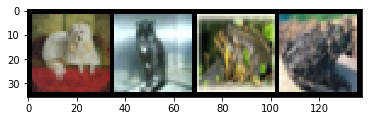

In [40]:
imshow(torchvision.utils.make_grid(images))

In [0]:
#Since all images on CPU bring the CNN network from GPU to CPU
net = net.to('cpu')

In [42]:
net.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [43]:
out = net.cnn_model[0](images)
out.shape

torch.Size([4, 6, 28, 28])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


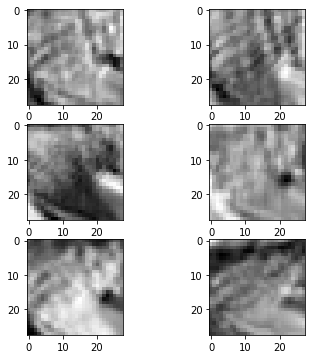

In [44]:
image_id = 3
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()


<h3> Visualising ouput of second Convolution layer </h3>





In [45]:
out3 = net.cnn_model[3](net.cnn_model[2](net.cnn_model[1](net.cnn_model[0](images))))
out3.shape

torch.Size([4, 16, 10, 10])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


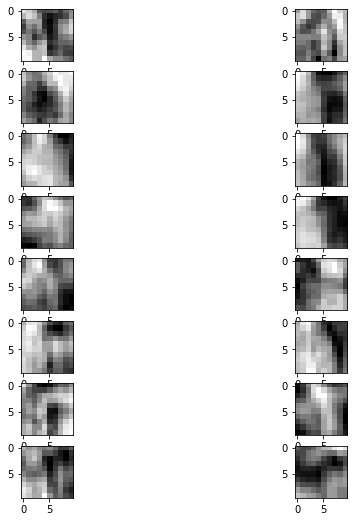

In [46]:
image_id = 1
plt.figure(figsize = (9,9))
plt.subplot(821)
for i in range(16):
    ax1 = plt.subplot(8, 2, i+1)
    plt.imshow(out3[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()